In [1]:
! pip install -q lalsuite
! pip install -q gwpy
! pip install -q pycbc
! pip install matplotlib==3.1.3
# -- Click "restart runtime" in the runtime menu

# -- download data
! wget https://www.gw-openscience.org/s/workshop3/challenge/challenge2.gwf

# -- for gwpy 
from gwpy.timeseries import TimeSeries
gwpy_strain = TimeSeries.read('challenge2.gwf', channel="H1:CHALLENGE2")

# -- for pycbc
from pycbc import frame
pycbc_strain = frame.read_frame('challenge2.gwf', 'H1:CHALLENGE2')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.4/48.4 MB 12.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.0/51.0 KB 4.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 22.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 299.7/299.7 KB 19.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.3/57.3 KB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.1/4.1 MB 58.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 19.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.4/45.4 KB 3.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.4/9.4 MB 64.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 965.4/965.4 KB 9.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━

[ 8.75332715e-22  1.27597248e-22  1.88838802e-22 ...
 -1.91886478e-23 -2.10989354e-22  2.30287965e-22]
The type of gwpy_strain is  <class 'gwpy.timeseries.timeseries.TimeSeries'>


(-16.0, -14.0)

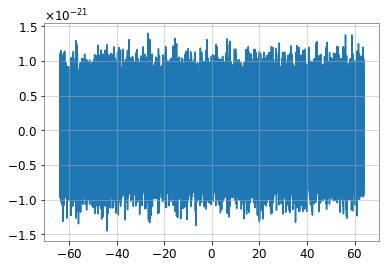

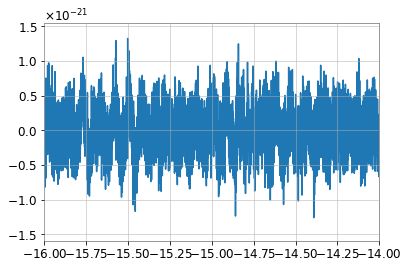

In [22]:
#%matplotlib inline

import pylab

print(pycbc_strain)
print('The type of gwpy_strain is ', type(gwpy_strain))

pylab.figure()
pylab.plot(pycbc_strain.sample_times,pycbc_strain)

#Adjusting time

pylab.figure(2)
pylab.plot(pycbc_strain.sample_times, pycbc_strain)
pylab.xlim(-16,-14)

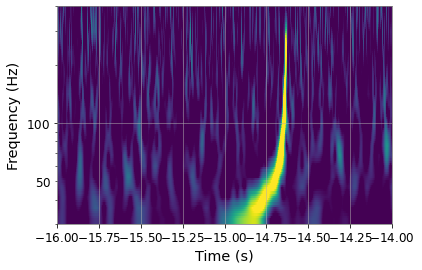

In [8]:
t, f, p = pycbc_strain.qtransform(.001, logfsteps=100, qrange=(8, 8), frange=(30, 400))
pylab.figure()
pylab.pcolormesh(t, f, p**0.5, vmin=1, vmax=6, shading='auto')
pylab.yscale('log')
pylab.xlabel('Time (s)')
pylab.ylabel('Frequency (Hz)')
pylab.xlim(-16, -14)
pylab.show()

Text(0, 0.5, 'Amplitude')

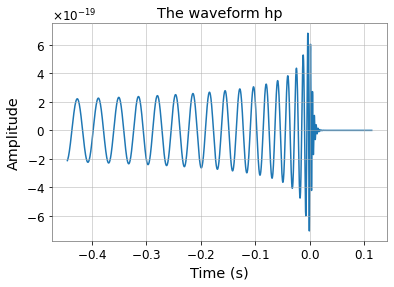

In [30]:
#Template
from pycbc.waveform import get_td_waveform
hp,hc = get_td_waveform(approximant="SEOBNRv4_opt",
                         mass1=30,
                         mass2=30,
                         delta_t=pycbc_strain.delta_t,
                         f_lower=25)

pylab.figure()
pylab.title("The waveform hp")
pylab.plot(hp.sample_times, hp)
pylab.xlabel('Time (s)')
pylab.ylabel('Amplitude')

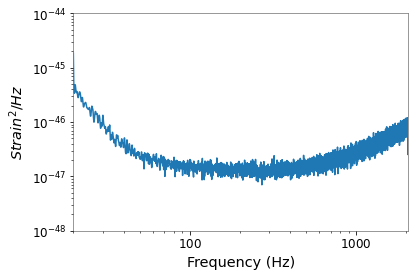

In [27]:
#This is the data
from pycbc.psd import interpolate, inverse_spectrum_truncation

psd = pycbc_strain.psd(4)

psd = interpolate(psd, pycbc_strain.delta_f)

psd = inverse_spectrum_truncation(psd, int(4 * pycbc_strain.sample_rate),
                                  low_frequency_cutoff=20)

pylab.plot(psd.sample_frequencies, psd)
pylab.yscale('log')
pylab.xscale('log')
pylab.ylabel('$Strain^2 / Hz$')
pylab.xlabel('Frequency (Hz)')
pylab.xlim(20,max(psd.sample_frequencies))
pylab.ylim(1e-48, 1e-44)
pylab.grid()
pylab.show()

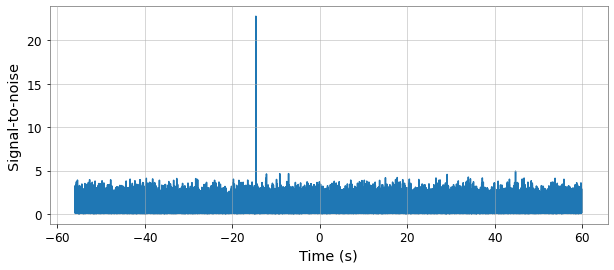

We found a signal at -14.6328125s with SNR 22.781427442795213


In [31]:
#SNR
from pycbc.filter import matched_filter

hp.resize(len(pycbc_strain))
template = hp.cyclic_time_shift(hp.start_time)


snr = matched_filter(template, pycbc_strain, psd=psd, low_frequency_cutoff=20)

snr = snr.crop(4 + 4, 4)

pylab.figure(figsize=[10, 4])
pylab.plot(snr.sample_times, abs(snr))
pylab.ylabel('Signal-to-noise')
pylab.xlabel('Time (s)')
pylab.show()

peak = abs(snr).numpy().argmax()
snrp = snr[peak]
time = snr.sample_times[peak]

print("We found a signal at {}s with SNR {}".format(time, 
                                                    abs(snrp)))